In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


# Fixed RandomSeed

In [ ]:
def seed_everything(seed) :
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(1004) # Seed 고정

## 입력경로, 특징, CSV 폴더 만들기

In [ ]:
import os
import pandas as pd

# 설정
input_dir = '/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/Data/gait-in-parkinsons-disease-1.0.0'
features = ['Time', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Total_Force_Left', 'Total_Force_Right']
os.makedirs('/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/CSV', exist_ok=True)


## txt --> csv

In [ ]:
# 데이터 CSV로 변환
for file in os.listdir(input_dir):
    if file[:2] in ['Ga', 'Ju', 'Si'] :
        df = pd.read_csv(os.path.join(input_dir, file), header=None, sep='\t', on_bad_lines='skip')
        df.columns = features
        df.to_csv(f'/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/CSV/{file.split(".")[0]}.csv', index=False)

## EDA 및 전처리(1)  --> 데이터 시간에 따른 압력 분포

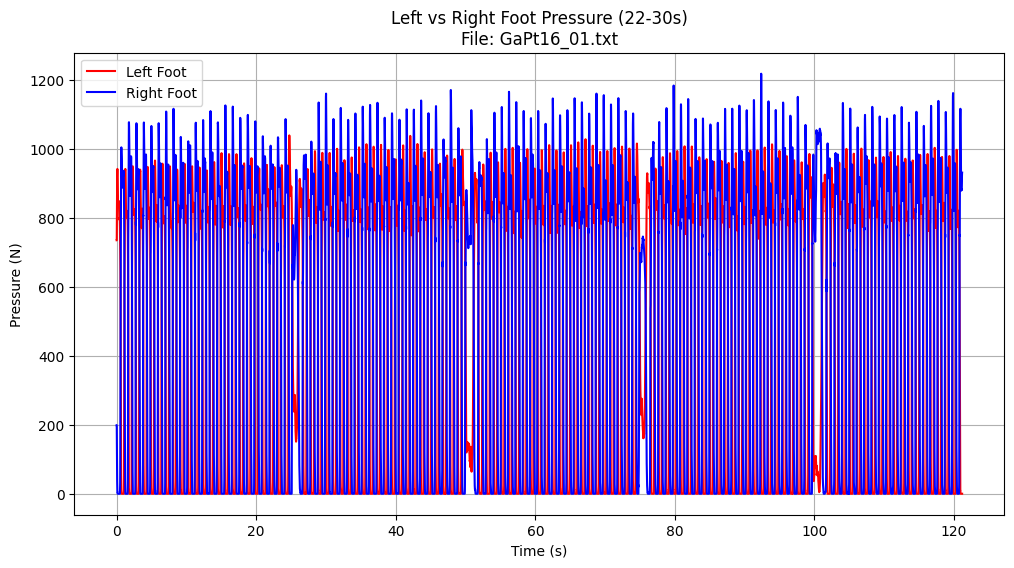

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os  # 파일 이름 추출을 위한 모듈 추가

def analyze_gait_asymmetry(file_path):
    # 파일 이름 추출
    file_name = os.path.basename(file_path)

    columns = ['Time'] + [f'L{i}' for i in range(1,9)] + [f'R{i}' for i in range(1,9)] + ['L_total', 'R_total']
    data = pd.read_csv(file_path, delimiter='\s+', names=columns)

    #구간 필터링
    mask = (data['Time'] >= 0) & (data['Time'] <= 300)
    filtered_data = data[mask]

    left_pressure = filtered_data['L_total']
    right_pressure = filtered_data['R_total']

    symmetry_index = np.abs(left_pressure - right_pressure) / ((left_pressure + right_pressure)/2)
    t_stat, p_value = stats.ttest_ind(left_pressure, right_pressure)

    results = {
        'file_name': file_name,  # 결과 딕셔너리에 파일 이름 추가
        'mean_symmetry_index': symmetry_index.mean() * 100,
        'p_value': p_value,
        'left_mean': left_pressure.mean(),
        'right_mean': right_pressure.mean()
    }

    # 그래프 생성
    fig = plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['Time'], filtered_data['L_total'], color='red', label='Left Foot')
    plt.plot(filtered_data['Time'], filtered_data['R_total'], color='blue', label='Right Foot')
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (N)')
    plt.title(f'Left vs Right Foot Pressure (22-30s)\nFile: {file_name}')  # 제목에 파일 이름 추가
    plt.legend()
    plt.grid(True)
    plt.show()

    return results, fig



# 사용 예시
file_path = "/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/Data/gait-in-parkinsons-disease-1.0.0/GaPt16_01.txt"
data = analyze_gait_asymmetry(file_path)

### 시간 : 25, 50, 75, 100 에서 공백과 같아보이는 현상 식별 --> 전처리 필요

### 아래 코드는 위 코드의 공백과 같아 보이는 것을 확대 한 것

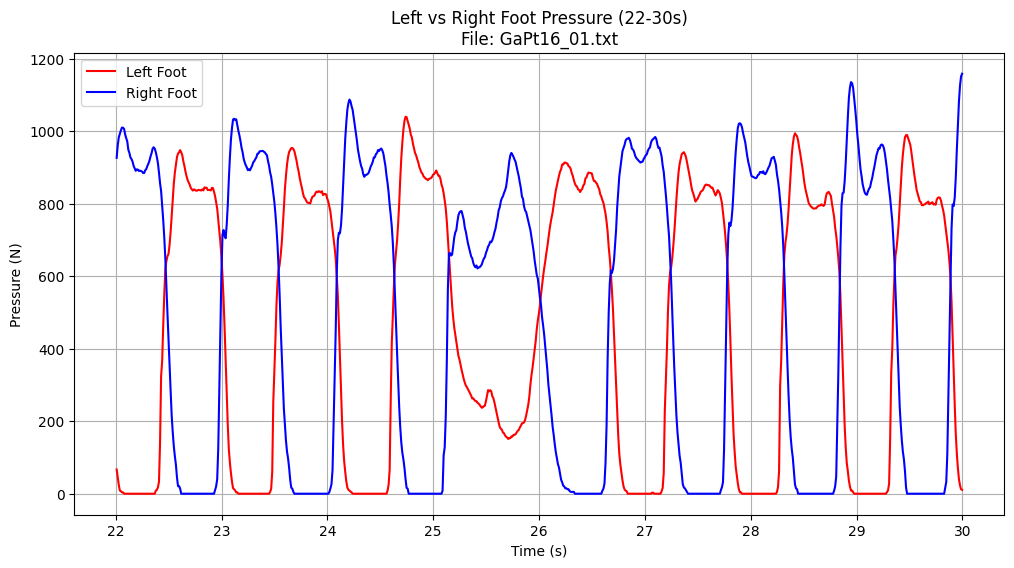

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os  # 파일 이름 추출을 위한 모듈 추가

def analyze_gait_asymmetry(file_path):
    # 파일 이름 추출
    file_name = os.path.basename(file_path)

    columns = ['Time'] + [f'L{i}' for i in range(1,9)] + [f'R{i}' for i in range(1,9)] + ['L_total', 'R_total']
    data = pd.read_csv(file_path, delimiter='\s+', names=columns)

    #구간 필터링
    mask = (data['Time'] >= 22) & (data['Time'] <= 30)
    filtered_data = data[mask]

    left_pressure = filtered_data['L_total']
    right_pressure = filtered_data['R_total']

    symmetry_index = np.abs(left_pressure - right_pressure) / ((left_pressure + right_pressure)/2)
    t_stat, p_value = stats.ttest_ind(left_pressure, right_pressure)

    results = {
        'file_name': file_name,  # 결과 딕셔너리에 파일 이름 추가
        'mean_symmetry_index': symmetry_index.mean() * 100,
        'p_value': p_value,
        'left_mean': left_pressure.mean(),
        'right_mean': right_pressure.mean()
    }

    # 그래프 생성
    fig = plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['Time'], filtered_data['L_total'], color='red', label='Left Foot')
    plt.plot(filtered_data['Time'], filtered_data['R_total'], color='blue', label='Right Foot')
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (N)')
    plt.title(f'Left vs Right Foot Pressure (22-30s)\nFile: {file_name}')  # 제목에 파일 이름 추가
    plt.legend()
    plt.grid(True)
    plt.show()

    return results, fig



# 사용 예시
file_path = "/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/Data/gait-in-parkinsons-disease-1.0.0/GaPt16_01.txt"
data = analyze_gait_asymmetry(file_path)

### 확대 결과 센서값이 25초 마다 찌그러지는 현상 식별

## EDA 및 전처리(2)  ## 데이터 패턴 보간 예시

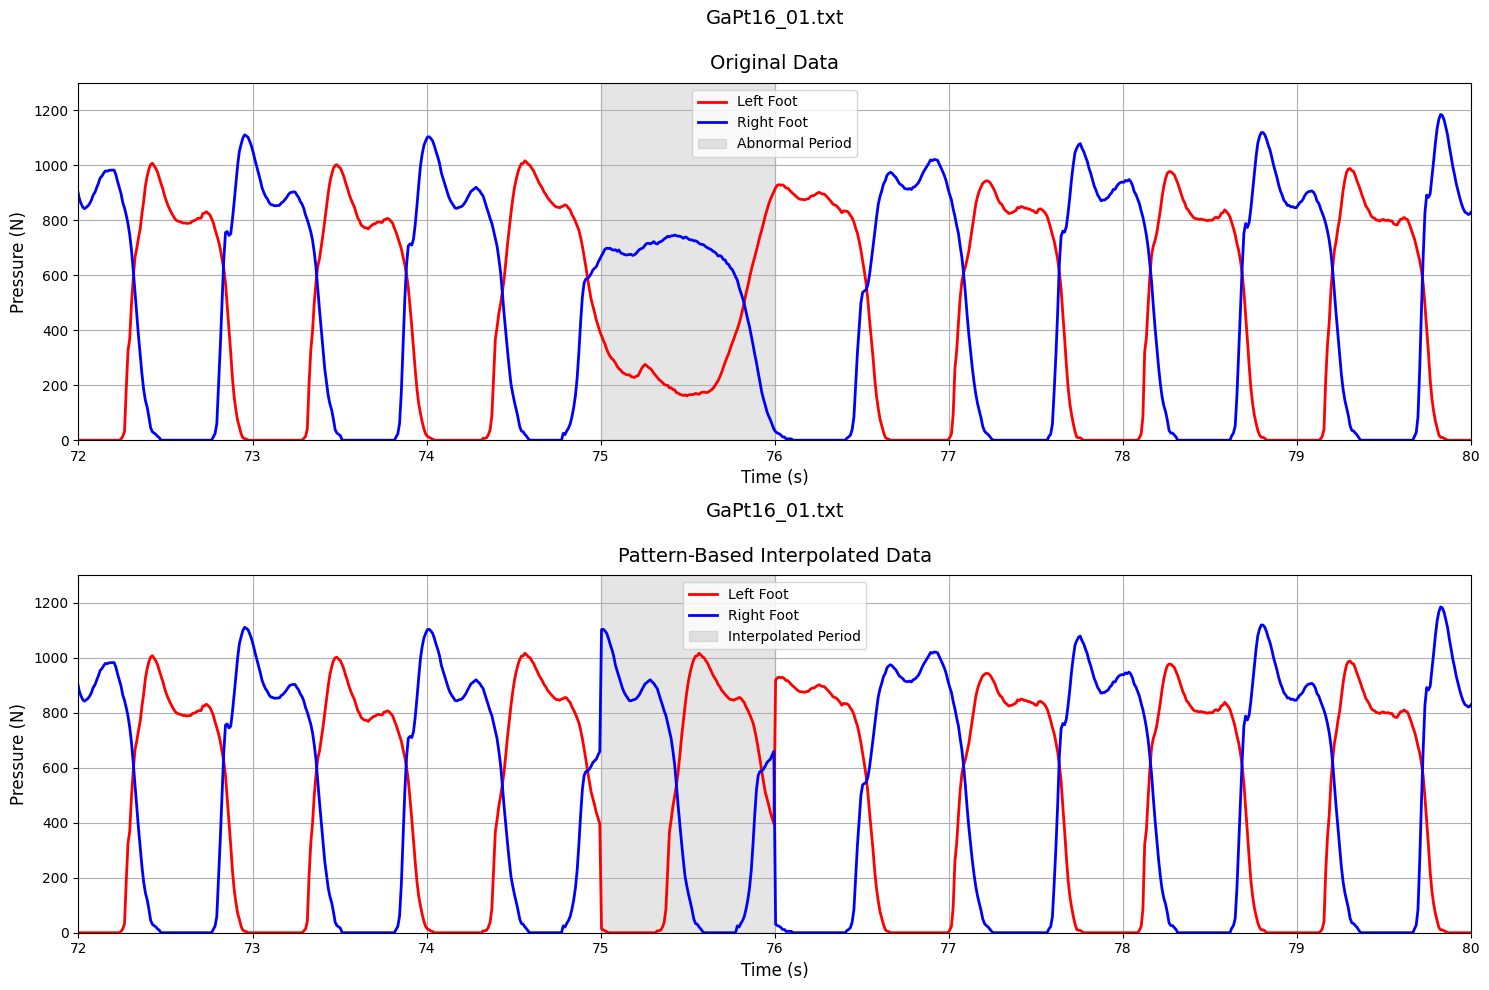


Interpolated period: 75s - 76s

Mean pressure in interpolated period:
Left Foot  - Original: 330.73N
Right Foot - Original: 611.34N
Left Foot  - Interpolated: 480.03N
Right Foot - Interpolated: 494.27N


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def pattern_based_interpolation(file_path, abnormal_start=75, abnormal_end=76, time_range=(72, 80)):
    """
    보행 패턴을 기반으로 비정상 구간을 보간하는 함수
    """
    # 파일 이름 추출
    file_name = os.path.basename(file_path)

    # 데이터 읽기
    df = pd.read_csv(file_path, sep='\t', header=None)
    df.columns = ['Time',
                 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8',
                 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8',
                 'Total_Force_Left', 'Total_Force_Right']


    # 보간된 데이터를 저장할 새로운 데이터프레임
    interpolated_df = df.copy()

    # 이전 정상 주기 찾기 (약 1초 주기)
    reference_start = abnormal_start - 1
    reference_end = abnormal_start

    # 비정상 구간의 시간 간격과 동일한 길이의 참조 데이터 생성
    abnormal_duration = abnormal_end - abnormal_start
    reference_data = df[(df['Time'] >= reference_start) & (df['Time'] < reference_end)]

    # 시간 조정을 위한 준비
    time_shift = abnormal_start - reference_start

    # 참조 데이터를 비정상 구간에 맞게 시간 이동
    for foot in ['Total_Force_Left', 'Total_Force_Right']:
        reference_times = reference_data['Time'].values
        reference_values = reference_data[foot].values

        new_times = reference_times + time_shift

        interpolator = np.interp(
            df[(df['Time'] >= abnormal_start) & (df['Time'] <= abnormal_end)]['Time'],
            new_times,
            reference_values
        )

        interpolated_df.loc[(df['Time'] >= abnormal_start) &
                          (df['Time'] <= abnormal_end), foot] = interpolator

    # 결과 시각화
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # 원본 데이터 그래프
    ax1.plot(df['Time'], df['Total_Force_Left'], 'r-', label='Left Foot', linewidth=2)
    ax1.plot(df['Time'], df['Total_Force_Right'], 'b-', label='Right Foot', linewidth=2)
    ax1.axvspan(abnormal_start, abnormal_end, color='gray', alpha=0.2, label='Abnormal Period')
    ax1.set_title(file_name + '\n\nOriginal Data', fontsize=14, pad=10)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('Pressure (N)', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True)
    ax1.set_xlim(time_range)
    ax1.set_ylim(0, 1300)

    # 보간된 데이터 그래프
    ax2.plot(interpolated_df['Time'], interpolated_df['Total_Force_Left'],
            'r-', label='Left Foot', linewidth=2)
    ax2.plot(interpolated_df['Time'], interpolated_df['Total_Force_Right'],
            'b-', label='Right Foot', linewidth=2)
    ax2.axvspan(abnormal_start, abnormal_end, color='gray', alpha=0.2, label='Interpolated Period')
    ax2.set_title(file_name + '\n\nPattern-Based Interpolated Data', fontsize=14, pad=10)
    ax2.set_xlabel('Time (s)', fontsize=12)
    ax2.set_ylabel('Pressure (N)', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True)
    ax2.set_xlim(time_range)
    ax2.set_ylim(0, 1300)

    plt.tight_layout()
    plt.show()

    # 보간 구간의 통계 정보 출력
    print(f"\nInterpolated period: {abnormal_start}s - {abnormal_end}s")
    print("\nMean pressure in interpolated period:")
    print(f"Left Foot  - Original: {df[(df['Time'] >= abnormal_start) & (df['Time'] <= abnormal_end)]['Total_Force_Left'].mean():.2f}N")
    print(f"Right Foot - Original: {df[(df['Time'] >= abnormal_start) & (df['Time'] <= abnormal_end)]['Total_Force_Right'].mean():.2f}N")
    print(f"Left Foot  - Interpolated: {interpolated_df[(interpolated_df['Time'] >= abnormal_start) & (interpolated_df['Time'] <= abnormal_end)]['Total_Force_Left'].mean():.2f}N")
    print(f"Right Foot - Interpolated: {interpolated_df[(interpolated_df['Time'] >= abnormal_start) & (interpolated_df['Time'] <= abnormal_end)]['Total_Force_Right'].mean():.2f}N")

    return interpolated_df

# 사용 예시
file_path = "/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/Data/gait-in-parkinsons-disease-1.0.0/GaPt16_01.txt"
interpolated_data = pattern_based_interpolation(file_path)

## EDA 및 전처리(3)  --> insight :  파킨슨 병 환자는 높은 압력에서 좌우 불균형이 큼

### 정상인 발 압력 데이터 분포

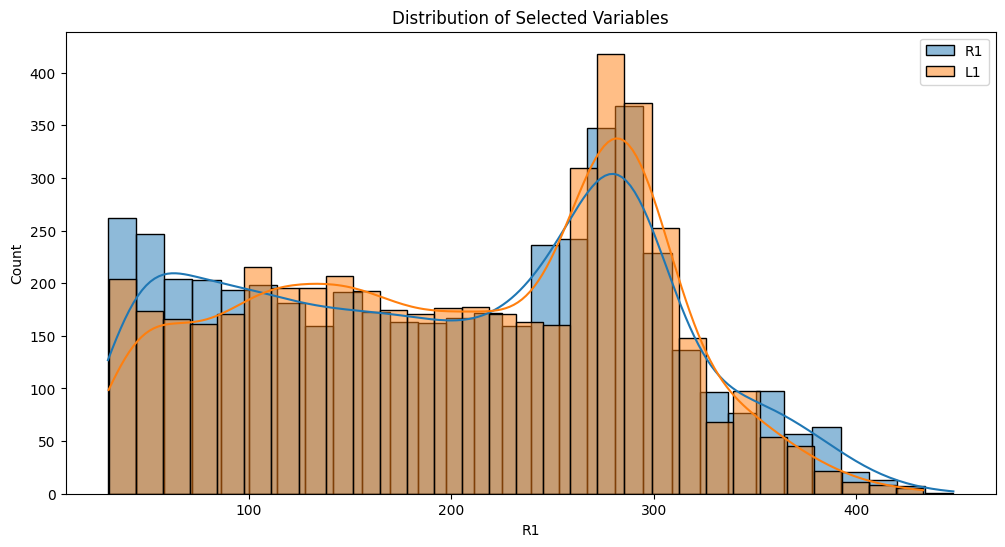

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 데이터 로드
ga_pt16_02_path = '/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/CSV/GaCo13_02.csv'
ga_pt16_02 = pd.read_csv(ga_pt16_02_path)



variables = ['R1', 'L1']
filtered_data = ga_pt16_02[(ga_pt16_02[variables] >= 30)]  # 모든 변수에서 10 이하 제외

# 히스토그램 비교
plt.figure(figsize=(12, 6))
for var in variables:
    sns.histplot(filtered_data[var], kde=True, label=var, bins=30)
plt.title("Distribution of Selected Variables")
plt.legend()
plt.show()

### 파킨슨 병 환자 발 압력 데이터 분포

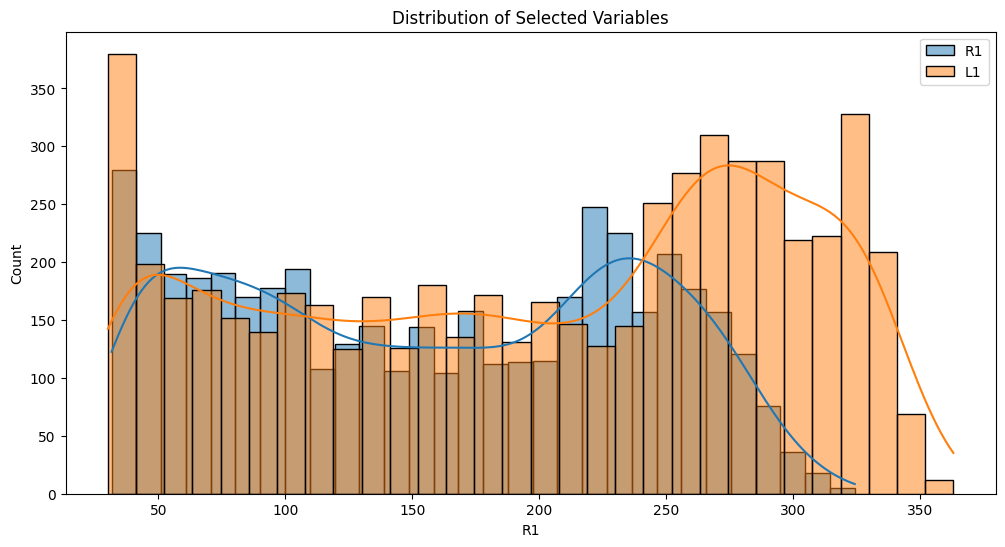

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 데이터 로드
ga_pt16_02_path = '/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/CSV/GaPt16_02.csv'  # 여기에 실제 경로를 입력하세요.
ga_pt16_02 = pd.read_csv(ga_pt16_02_path)



variables = ['R1', 'L1']
filtered_data = ga_pt16_02[(ga_pt16_02[variables] >= 30)]  # 모든 변수에서 10 이하 제외

# 히스토그램 비교
plt.figure(figsize=(12, 6))
for var in variables:
    sns.histplot(filtered_data[var], kde=True, label=var, bins=30)
plt.title("Distribution of Selected Variables")
plt.legend()
plt.show()

## EDA 및 전처리(4)  --> 일반인 데이터에서 파킨슨 병 환자 같은 증상 보임 == 노이즈 데이터

### 노이즈 데이터 찾는 코드

In [ ]:
import pandas as pd
import glob
import numpy as np

def analyze_gait_balance(folder_path):
    # Get all Co*.csv files in the specified directory
    file_pattern = folder_path + '/*Co*.csv'
    files = glob.glob(file_pattern)

    # Store imbalanced files
    imbalanced_files = []

    # Threshold for imbalance
    threshold = 0.3  # 10% difference

    for file in files:
        try:
            # Read the CSV file
            df = pd.read_csv(file)

            # Check for each pair from L1-R1 to L8-R8
            imbalance_details = []

            for i in range(1, 9):
                left_col = f'L{i}'
                right_col = f'R{i}'

                if left_col in df.columns and right_col in df.columns:
                    # Calculate mean values
                    left_mean = df[left_col].mean()
                    right_mean = df[right_col].mean()

                    # Calculate relative difference
                    max_val = max(abs(left_mean), abs(right_mean))
                    if max_val != 0:
                        relative_diff = abs(left_mean - right_mean) / max_val

                        if relative_diff > threshold:
                            imbalance_details.append(
                                f"{left_col}-{right_col}: {relative_diff:.2%} difference"
                            )

            # Only add to results if 4 or more pairs show imbalance
            if len(imbalance_details) >= 4:
                file_name = file.split('/')[-1]
                imbalanced_files.append({
                    'file': file_name,
                    'details': imbalance_details,
                    'imbalance_count': len(imbalance_details)
                })

        except Exception as e:
            print(f"Error processing {file}: {str(e)}")

    return imbalanced_files

# 사용 예시
folder_path = '/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/CSV'  # 파일들이 있는 폴더 경로
results = analyze_gait_balance(folder_path)

# 결과 출력
if results:
    print("\n4개 이상의 불균형이 감지된 파일들:")
    for result in results:
        print(f"\n파일: {result['file']}")
        print(f"불균형 쌍의 개수: {result['imbalance_count']}")
        print("불균형 상세:")
        for detail in result['details']:
            print(f"  - {detail}")
else:
    print("\n4개 이상의 불균형 쌍을 가진 파일이 없습니다.")


4개 이상의 불균형이 감지된 파일들:

파일: SiCo10_01.csv
불균형 쌍의 개수: 4
불균형 상세:
  - L4-R4: 40.98% difference
  - L5-R5: 61.16% difference
  - L7-R7: 37.34% difference
  - L8-R8: 54.36% difference

파일: SiCo24_01.csv
불균형 쌍의 개수: 4
불균형 상세:
  - L2-R2: 38.43% difference
  - L4-R4: 31.12% difference
  - L5-R5: 39.16% difference
  - L8-R8: 34.43% difference

파일: JuCo15_01.csv
불균형 쌍의 개수: 4
불균형 상세:
  - L2-R2: 38.68% difference
  - L5-R5: 54.20% difference
  - L6-R6: 30.65% difference
  - L8-R8: 47.36% difference

파일: JuCo25_01.csv
불균형 쌍의 개수: 4
불균형 상세:
  - L5-R5: 50.36% difference
  - L6-R6: 32.92% difference
  - L7-R7: 30.68% difference
  - L8-R8: 52.43% difference


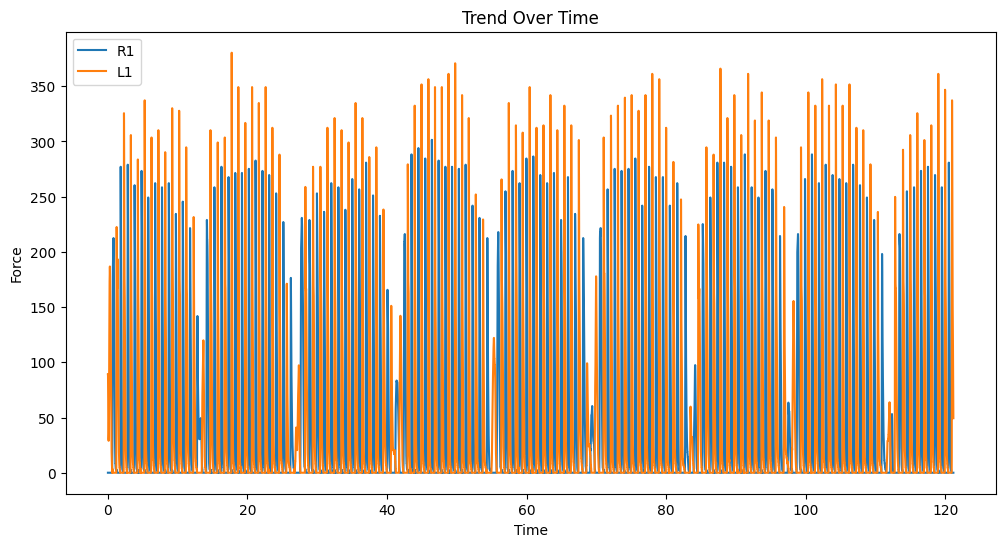

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# GaCo16_02

# 데이터 로드
ga_pt16_02_path = '/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/CSV/GaCo16_02.csv'
ga_pt16_02 = pd.read_csv(ga_pt16_02_path)


# 주요 변수 선택
variables = ['R1', 'L1']


# 시간에 따른 추세 그래프
if 'Time' in ga_pt16_02.columns:
    plt.figure(figsize=(12, 6))
    for var in variables:
        sns.lineplot(x=ga_pt16_02['Time'], y=ga_pt16_02[var], label=var)
    plt.title("Trend Over Time")
    plt.xlabel("Time")
    plt.ylabel("Force")
    plt.legend()
    plt.show()
else:
    print("Time column is not available in the dataset for trend analysis.")


## 노이즈 데이터 제거 코드

In [ ]:
import pandas as pd
import glob
import numpy as np
import shutil
import os

def analyze_and_filter_data(source_folder, target_folder):
    # Get all Co*.csv files in the specified directory
    file_pattern = source_folder + '/*Co*.csv'
    files = glob.glob(file_pattern)

    # Store imbalanced files
    imbalanced_files = set()  # Using set for faster lookup

    # Threshold for imbalance
    threshold = 0.3  # 20% difference

    # First pass: identify files with 4+ imbalances
    for file in files:
        try:
            df = pd.read_csv(file)
            imbalance_count = 0

            for i in range(1, 9):
                left_col = f'L{i}'
                right_col = f'R{i}'

                if left_col in df.columns and right_col in df.columns:
                    # Calculate mean values
                    left_mean = df[left_col].mean()
                    right_mean = df[right_col].mean()

                    # Calculate relative difference
                    max_val = max(abs(left_mean), abs(right_mean))
                    if max_val != 0:
                        relative_diff = abs(left_mean - right_mean) / max_val

                        if relative_diff > threshold:
                            imbalance_count += 1

            if imbalance_count >= 4:
                file_name = file.split('/')[-1]
                imbalanced_files.add(file_name)

        except Exception as e:
            print(f"Error analyzing {file}: {str(e)}")

    # Create target directory if it doesn't exist
    os.makedirs(target_folder, exist_ok=True)

    # Second pass: copy balanced files to new directory
    copied_files = []
    for file in files:
        file_name = file.split('/')[-1]
        if file_name not in imbalanced_files:
            try:
                shutil.copy2(file, os.path.join(target_folder, file_name))
                copied_files.append(file_name)
            except Exception as e:
                print(f"Error copying {file}: {str(e)}")

    return {
        'excluded_count': len(imbalanced_files),
        'excluded_files': sorted(list(imbalanced_files)),
        'copied_count': len(copied_files),
        'copied_files': sorted(copied_files)
    }

# 사용 예시
source_folder = '/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/CSV'  # 원본 파일들이 있는 폴더 경로
target_folder = '/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/CSV_Balanced'  # 균형 잡힌 파일들을 복사할 폴더 경로

results = analyze_and_filter_data(source_folder, target_folder)

# 결과 출력
print(f"\n처리 결과:")
print(f"제외된 파일 수: {results['excluded_count']}")
print(f"복사된 파일 수: {results['copied_count']}")

print("\n제외된 파일들 (4개 이상 불균형):")
for file in results['excluded_files']:
    print(f"  - {file}")

print("\n선택된 파일들 (균형 잡힌 데이터):")
for file in results['copied_files']:
    print(f"  - {file}")

print(f"\n균형 잡힌 파일들이 {target_folder}에 복사되었습니다.")


처리 결과:
제외된 파일 수: 4
복사된 파일 수: 88

제외된 파일들 (4개 이상 불균형):
  - JuCo15_01.csv
  - JuCo25_01.csv
  - SiCo10_01.csv
  - SiCo24_01.csv

선택된 파일들 (균형 잡힌 데이터):
  - GaCo01_01.csv
  - GaCo02_01.csv
  - GaCo02_02.csv
  - GaCo03_01.csv
  - GaCo03_02.csv
  - GaCo04_01.csv
  - GaCo04_02.csv
  - GaCo05_01.csv
  - GaCo05_02.csv
  - GaCo06_01.csv
  - GaCo06_02.csv
  - GaCo07_01.csv
  - GaCo07_02.csv
  - GaCo08_01.csv
  - GaCo08_02.csv
  - GaCo09_01.csv
  - GaCo09_02.csv
  - GaCo10_01.csv
  - GaCo10_02.csv
  - GaCo11_01.csv
  - GaCo12_01.csv
  - GaCo13_01.csv
  - GaCo13_02.csv
  - GaCo13_10.csv
  - GaCo14_01.csv
  - GaCo14_02.csv
  - GaCo14_10.csv
  - GaCo15_01.csv
  - GaCo15_02.csv
  - GaCo15_10.csv
  - GaCo16_01.csv
  - GaCo16_02.csv
  - GaCo16_10.csv
  - GaCo17_01.csv
  - GaCo17_02.csv
  - GaCo17_10.csv
  - GaCo22_01.csv
  - GaCo22_10.csv
  - JuCo01_01.csv
  - JuCo02_01.csv
  - JuCo03_01.csv
  - JuCo04_01.csv
  - JuCo05_01.csv
  - JuCo06_01.csv
  - JuCo07_01.csv
  - JuCo08_01.csv
  - JuCo09_01.csv
  - J

In [ ]:
import pandas as pd
import glob
import numpy as np
import os
import shutil
from datetime import datetime

def analyze_gait_balance(folder_path, action='move'):
    """
    Analyze gait balance and handle imbalanced files.

    Parameters:
    folder_path (str): Path to the directory containing CSV files
    action (str): 'move' to move files to backup, 'delete' to remove files directly
    """
    # Get all Co*.csv files in the specified directory
    file_pattern = folder_path + '/*Co*.csv'
    files = glob.glob(file_pattern)

    # Store imbalanced files
    imbalanced_files = []

    # Threshold for imbalance
    threshold = 0.30  # 40% difference

    for file in files:
        try:
            # Read the CSV file
            df = pd.read_csv(file)

            # Check for each pair from L1-R1 to L8-R8
            imbalance_details = []

            for i in range(1, 9):
                left_col = f'L{i}'
                right_col = f'R{i}'

                if left_col in df.columns and right_col in df.columns:
                    # Calculate mean values
                    left_mean = df[left_col].mean()
                    right_mean = df[right_col].mean()

                    # Calculate relative difference
                    max_val = max(abs(left_mean), abs(right_mean))
                    if max_val != 0:
                        relative_diff = abs(left_mean - right_mean) / max_val

                        if relative_diff > threshold:
                            imbalance_details.append(
                                f"{left_col}-{right_col}: {relative_diff:.2%} difference"
                            )

            # Only add to results if 4 or more pairs show imbalance
            if len(imbalance_details) >= 4:
                file_name = file.split('/')[-1]
                imbalanced_files.append({
                    'file': file,  # Store full path
                    'file_name': file_name,
                    'details': imbalance_details,
                    'imbalance_count': len(imbalance_details)
                })

        except Exception as e:
            print(f"Error processing {file}: {str(e)}")

    if imbalanced_files:
        if action == 'move':
            # Create backup directory with timestamp
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            backup_dir = os.path.join(folder_path, f'imbalanced_backup_{timestamp}')
            os.makedirs(backup_dir, exist_ok=True)

            # Move files to backup
            for result in imbalanced_files:
                try:
                    shutil.move(result['file'], os.path.join(backup_dir, result['file_name']))
                    print(f"Moved {result['file_name']} to backup directory")
                except Exception as e:
                    print(f"Error moving {result['file_name']}: {str(e)}")

        elif action == 'delete':
            # Delete files directly
            for result in imbalanced_files:
                try:
                    os.remove(result['file'])
                    print(f"Deleted {result['file_name']}")
                except Exception as e:
                    print(f"Error deleting {result['file_name']}: {str(e)}")

    return imbalanced_files

# 사용 예시
folder_path = '/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/CSV'

# 파일을 백업 디렉토리로 이동하는 경우 (권장)
results = analyze_gait_balance(folder_path, action='move')

# 또는 파일을 직접 삭제하는 경우
# results = analyze_gait_balance(folder_path, action='delete')

# 결과 출력
if results:
    print("\n4개 이상의 불균형이 감지된 파일들:")
    for result in results:
        print(f"\n파일: {result['file_name']}")
        print(f"불균형 쌍의 개수: {result['imbalance_count']}")
        print("불균형 상세:")
        for detail in result['details']:
            print(f"  - {detail}")
else:
    print("\n4개 이상의 불균형 쌍을 가진 파일이 없습니다.")

Moved SiCo10_01.csv to backup directory
Moved SiCo24_01.csv to backup directory
Moved JuCo15_01.csv to backup directory
Moved JuCo25_01.csv to backup directory

4개 이상의 불균형이 감지된 파일들:

파일: SiCo10_01.csv
불균형 쌍의 개수: 4
불균형 상세:
  - L4-R4: 40.98% difference
  - L5-R5: 61.16% difference
  - L7-R7: 37.34% difference
  - L8-R8: 54.36% difference

파일: SiCo24_01.csv
불균형 쌍의 개수: 4
불균형 상세:
  - L2-R2: 38.43% difference
  - L4-R4: 31.12% difference
  - L5-R5: 39.16% difference
  - L8-R8: 34.43% difference

파일: JuCo15_01.csv
불균형 쌍의 개수: 4
불균형 상세:
  - L2-R2: 38.68% difference
  - L5-R5: 54.20% difference
  - L6-R6: 30.65% difference
  - L8-R8: 47.36% difference

파일: JuCo25_01.csv
불균형 쌍의 개수: 4
불균형 상세:
  - L5-R5: 50.36% difference
  - L6-R6: 32.92% difference
  - L7-R7: 30.68% difference
  - L8-R8: 52.43% difference


## pt == 5프로   1개  //    Co == 30 프로  9 개

## Demographics 로드

In [ ]:
# Demographics 로드
demographics = pd.read_csv(os.path.join(input_dir, '/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/Data/gait-in-parkinsons-disease-1.0.0/demographics.txt'), sep='\s+')

## CustomDataset

In [ ]:
features = ['R1', 'L5']

class GaitDataset(Dataset):
    def __init__(self, csv_dir, demographics, features, window_size=400, skip=50):
        """
        GaitDataset 초기화 함수

        Parameters:
        csv_dir (str): CSV 파일 디렉토리 경로
        demographics (pd.DataFrame): 'ID'와 'Group' 정보를 포함한 데이터프레임
        features (list): CSV에서 사용할 피처 리스트
        window_size (int): 슬라이딩 윈도우 크기
        skip (int): 슬라이딩 윈도우 건너뛰는 간격
        """
        self.data = []
        self.labels = []
        self.features = features
        self.window_size = window_size
        self.skip = skip
        self.demographics = demographics

        unmatched_files = 0  # 매칭되지 않은 파일 수를 카운트
        missing_feature_files = 0  # 피처가 누락된 파일 수를 카운트

        for file in os.listdir(csv_dir):
            sub_id = file.split('_')[0]

            # 매칭되지 않는 ID 건너뛰기
            filtered = self.demographics[self.demographics['ID'] == sub_id]['Group'].values
            if len(filtered) == 0:
                unmatched_files += 1
                print(f"Warning: No matching ID for {sub_id}. Skipping file: {file}")
                continue

            label = filtered[0] - 1  # Label 가져오기

            # CSV 파일 로드
            df = pd.read_csv(os.path.join(csv_dir, file))

            # 필요한 피처가 모두 있는지 확인
            if not set(features).issubset(df.columns):
                missing_feature_files += 1
                print(f"Warning: Missing features in file: {file}. Required: {features}")
                continue

            # 필요한 피처만 선택
            df = df[self.features]
            print(f"Using features: {df.columns.tolist()} from file: {file}")  # 확인용 출력

            # 슬라이딩 윈도우로 데이터 분할
            for start in range(0, len(df) - window_size, skip):
                segment = df.iloc[start:start + window_size].values
                self.data.append(segment)
                self.labels.append(label)

        # 데이터를 NumPy 배열로 변환
        self.data = np.array(self.data, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)

        # 처리 결과 출력
        print(f"\nDataset creation completed:")
        print(f"  Total unmatched files skipped: {unmatched_files}")
        print(f"  Total files with missing features skipped: {missing_feature_files}")
        print(f"  Total data segments: {len(self.data)}")
        print(f"  Total labels: {len(self.labels)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 슬라이싱된 데이터를 반환
        return torch.tensor(self.data[idx]), self.labels[idx]


## train_test_split

In [ ]:
# 데이터셋 로드
dataset = GaitDataset('/content/drive/MyDrive/02_글로벌인턴십/03_최종산출물/CSV', demographics, features)
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size


Using features: ['R1', 'L5'] from file: GaPt03_01.csv
Using features: ['R1', 'L5'] from file: SiPt02_01.csv
Using features: ['R1', 'L5'] from file: SiPt04_01.csv
Using features: ['R1', 'L5'] from file: GaPt04_01.csv
Using features: ['R1', 'L5'] from file: SiPt05_01.csv
Using features: ['R1', 'L5'] from file: GaPt05_01.csv
Using features: ['R1', 'L5'] from file: SiPt07_01.csv
Using features: ['R1', 'L5'] from file: GaPt06_01.csv
Using features: ['R1', 'L5'] from file: SiPt08_01.csv
Using features: ['R1', 'L5'] from file: SiPt09_01.csv
Using features: ['R1', 'L5'] from file: GaPt07_01.csv
Using features: ['R1', 'L5'] from file: SiPt10_01.csv
Using features: ['R1', 'L5'] from file: GaPt07_02.csv
Using features: ['R1', 'L5'] from file: GaPt08_01.csv
Using features: ['R1', 'L5'] from file: GaPt08_02.csv
Using features: ['R1', 'L5'] from file: SiPt12_01.csv
Using features: ['R1', 'L5'] from file: GaPt09_01.csv
Using features: ['R1', 'L5'] from file: SiPt13_01.csv
Using features: ['R1', 'L5']

## Data Loader

In [ ]:
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## Moddel Define

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# GRU 모델 정의 + Attention 적용
class GRUModelWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModelWithAttention, self).__init__()

        # GRU 레이어 정의
        # input_size: 입력 특성의 차원, hidden_size: GRU의 은닉 상태 크기, num_layers: GRU 레이어의 개수
        # batch_first=True는 입력 텐서가 (배치 크기, 시퀀스 길이, 입력 차원) 순서를 따르도록 설정
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)


        # Attention 점수 계산을 위한 선형 레이어
        # hidden_size를 받아서 각 타임스텝에 대해 1개의 스칼라 점수로 변환
        self.attention = nn.Linear(hidden_size, 1)  # Attention score for each time step


        # Fully Connected Layer (출력 레이어)
        # 은닉 상태를 입력받아 최종 출력 크기 (output_size)로 변환
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 128),  # 은닉 상태에서 128차원으로 변환
            nn.ReLU(),                   # 활성화 함수로 ReLU 사용
            nn.Dropout(0.5),             # 드롭아웃 적용 (0.5 비율로 뉴런 비활성화)
            nn.Linear(128, output_size)  # 128차원에서 최종 출력 크기 (output_size)로 변환
        )

    def forward(self, x):
        # GRU는 (배치 크기, 시퀀스 길이, 입력 차원) 순서의 입력을 받음
        out, hn = self.gru(x)  # out: (배치 크기, 시퀀스 길이, 은닉 상태 크기)

        # Attention 메커니즘 적용
        # 각 타임스텝에 대해 Attention 점수 계산
        attention_scores = self.attention(out)  # (배치 크기, 시퀀스 길이, 1)
        # Attention 점수에 대해 소프트맥스 적용 (시퀀스 길이 차원에서 정규화)
        attention_weights = F.softmax(attention_scores, dim=1)  # (배치 크기, 시퀀스 길이, 1)
        # Attention 가중치를 사용하여 GRU 출력의 가중합 계산
        context_vector = torch.sum(out * attention_weights, dim=1)  # (배치 크기, 은닉 상태 크기)


        # Fully Connected Layer 통과하여 최종 출력 생성
        out = self.fc(context_vector)  # 최종 출력
        return out, attention_weights  # 모델 출력과 Attention 가중치 반환


In [ ]:
input_size = len(features)

In [ ]:
input_size = len(features)
print(input_size)

2


In [ ]:
from torchsummary import summary

# 모델 및 입력 크기 정의
input_size = len(features)  # 사용된 특징(feature) 개수
hidden_size = 128
num_layers = 2
output_size = 2  # 이진 분류
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 초기화
model = GRUModelWithAttention(input_size, hidden_size, num_layers, output_size).to(device)

# 모델 요약 출력
# input_size = (400, input_size): GRU 모델에 대한 입력 크기 (시퀀스 길이 400, 특징 개수 input_size)
summary(model, input_size=(400, input_size))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 400, 128], [-1, 2, 128]]               0
            Linear-2               [-1, 400, 1]             129
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                    [-1, 2]             258
Total params: 16,899
Trainable params: 16,899
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 99.99
Params size (MB): 0.06
Estimated Total Size (MB): 100.06
----------------------------------------------------------------


In [ ]:
# 모델 초기화
input_size = len(features)
hidden_size = 128

num_layers = 2
output_size = 2  # Binary classification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GRUModelWithAttention(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


## Parameter 계산

In [ ]:
# 모델 파라미터를 게산하는 모델
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")


Total Parameters: 166659
Trainable Parameters: 166659


## ## Train, Eval, Test

In [ ]:
# train_model 수정
def train_model(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(loader):
        inputs = inputs.to(device)  # (batch_size, seq_length, input_size)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)  # Attention weights 무시
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    train_loss = running_loss / len(loader)
    train_precision = precision_score(all_labels, all_preds, average='weighted')
    train_recall = recall_score(all_labels, all_preds, average='weighted')
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    return train_loss, train_precision, train_recall, train_f1



# evaluate_model 수정
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs, _ = model(inputs)  # Attention weights 무시
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    val_loss = running_loss / len(loader)
    val_precision = precision_score(all_labels, all_preds, average='weighted')
    val_recall = recall_score(all_labels, all_preds, average='weighted')
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    return val_loss, val_precision, val_recall, val_f1

# 테스트 평가 함수
def test_model(model, loader, criterion):
    print("\nEvaluating on Test Data...")
    test_loss, test_precision, test_recall, test_f1 = evaluate_model(model, loader, criterion)
    print(f"Test -> Loss: {test_loss:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")


# 학습 및 검증
best_val_f1 = 0  # 모델 저장 기준
model_path = "best_GRU_Attention_model.pth"
epochs = 20

for epoch in range(epochs) :
    train_loss, train_precision, train_recall, train_f1 = train_model(model, train_loader, criterion, optimizer)
    val_loss, val_precision, val_recall, val_f1 = evaluate_model(model, valid_loader, criterion)

    print(f"Epoch {epoch + 1}/{epochs}:")
    print(f"  Train -> Loss: {train_loss:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}")
    print(f"  Val   -> Loss: {val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}")

    if val_f1 > best_val_f1 :
        best_val_f1 = val_f1
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at epoch {epoch + 1}")


# 최적 모델 로드 및 테스트 평가
print("\nLoading the best model for evaluation...")
model.load_state_dict(torch.load(model_path))
model.to(device)

test_model(model, test_loader, criterion)

100%|██████████| 1385/1385 [00:10<00:00, 127.17it/s]


Epoch 1/20:
  Train -> Loss: 0.3270, Precision: 0.8484, Recall: 0.8514, F1-Score: 0.8461
  Val   -> Loss: 0.1788, Precision: 0.9311, Recall: 0.9305, F1-Score: 0.9307
Model saved at epoch 1


100%|██████████| 1385/1385 [00:10<00:00, 135.88it/s]


Epoch 2/20:
  Train -> Loss: 0.1508, Precision: 0.9417, Recall: 0.9420, F1-Score: 0.9418
  Val   -> Loss: 0.1410, Precision: 0.9496, Recall: 0.9475, F1-Score: 0.9480
Model saved at epoch 2


100%|██████████| 1385/1385 [00:10<00:00, 135.38it/s]


Epoch 3/20:
  Train -> Loss: 0.1043, Precision: 0.9620, Recall: 0.9621, F1-Score: 0.9621
  Val   -> Loss: 0.0869, Precision: 0.9668, Recall: 0.9660, F1-Score: 0.9662
Model saved at epoch 3


100%|██████████| 1385/1385 [00:10<00:00, 137.13it/s]


Epoch 4/20:
  Train -> Loss: 0.0746, Precision: 0.9726, Recall: 0.9727, F1-Score: 0.9726
  Val   -> Loss: 0.1219, Precision: 0.9571, Recall: 0.9560, F1-Score: 0.9551


100%|██████████| 1385/1385 [00:10<00:00, 134.33it/s]


Epoch 5/20:
  Train -> Loss: 0.0586, Precision: 0.9785, Recall: 0.9785, F1-Score: 0.9785
  Val   -> Loss: 0.0707, Precision: 0.9779, Recall: 0.9776, F1-Score: 0.9773
Model saved at epoch 5


100%|██████████| 1385/1385 [00:10<00:00, 131.29it/s]


Epoch 6/20:
  Train -> Loss: 0.0508, Precision: 0.9812, Recall: 0.9812, F1-Score: 0.9812
  Val   -> Loss: 0.0419, Precision: 0.9841, Recall: 0.9841, F1-Score: 0.9840
Model saved at epoch 6


100%|██████████| 1385/1385 [00:10<00:00, 130.59it/s]


Epoch 7/20:
  Train -> Loss: 0.0456, Precision: 0.9828, Recall: 0.9829, F1-Score: 0.9829
  Val   -> Loss: 0.0535, Precision: 0.9807, Recall: 0.9804, F1-Score: 0.9802


100%|██████████| 1385/1385 [00:10<00:00, 130.54it/s]


Epoch 8/20:
  Train -> Loss: 0.0379, Precision: 0.9860, Recall: 0.9860, F1-Score: 0.9860
  Val   -> Loss: 0.0306, Precision: 0.9882, Recall: 0.9881, F1-Score: 0.9881
Model saved at epoch 8


100%|██████████| 1385/1385 [00:10<00:00, 130.53it/s]


Epoch 9/20:
  Train -> Loss: 0.0361, Precision: 0.9863, Recall: 0.9863, F1-Score: 0.9863
  Val   -> Loss: 0.0549, Precision: 0.9833, Recall: 0.9832, F1-Score: 0.9832


100%|██████████| 1385/1385 [00:10<00:00, 128.01it/s]


Epoch 10/20:
  Train -> Loss: 0.0344, Precision: 0.9869, Recall: 0.9869, F1-Score: 0.9869
  Val   -> Loss: 0.0282, Precision: 0.9887, Recall: 0.9887, F1-Score: 0.9887
Model saved at epoch 10


100%|██████████| 1385/1385 [00:10<00:00, 127.68it/s]


Epoch 11/20:
  Train -> Loss: 0.0292, Precision: 0.9889, Recall: 0.9889, F1-Score: 0.9889
  Val   -> Loss: 0.0293, Precision: 0.9898, Recall: 0.9898, F1-Score: 0.9898
Model saved at epoch 11


100%|██████████| 1385/1385 [00:10<00:00, 129.03it/s]


Epoch 12/20:
  Train -> Loss: 0.0279, Precision: 0.9888, Recall: 0.9888, F1-Score: 0.9888
  Val   -> Loss: 0.0423, Precision: 0.9834, Recall: 0.9834, F1-Score: 0.9834


100%|██████████| 1385/1385 [00:10<00:00, 129.88it/s]


Epoch 13/20:
  Train -> Loss: 0.0272, Precision: 0.9897, Recall: 0.9897, F1-Score: 0.9897
  Val   -> Loss: 0.0324, Precision: 0.9880, Recall: 0.9880, F1-Score: 0.9879


100%|██████████| 1385/1385 [00:10<00:00, 132.12it/s]


Epoch 14/20:
  Train -> Loss: 0.0259, Precision: 0.9897, Recall: 0.9897, F1-Score: 0.9897
  Val   -> Loss: 0.0720, Precision: 0.9792, Recall: 0.9787, F1-Score: 0.9785


100%|██████████| 1385/1385 [00:10<00:00, 131.31it/s]


Epoch 15/20:
  Train -> Loss: 0.0234, Precision: 0.9908, Recall: 0.9908, F1-Score: 0.9908
  Val   -> Loss: 0.0264, Precision: 0.9902, Recall: 0.9902, F1-Score: 0.9902
Model saved at epoch 15


100%|██████████| 1385/1385 [00:10<00:00, 127.74it/s]


Epoch 16/20:
  Train -> Loss: 0.0229, Precision: 0.9906, Recall: 0.9906, F1-Score: 0.9906
  Val   -> Loss: 0.0403, Precision: 0.9879, Recall: 0.9879, F1-Score: 0.9879


100%|██████████| 1385/1385 [00:10<00:00, 127.85it/s]


Epoch 17/20:
  Train -> Loss: 0.0231, Precision: 0.9911, Recall: 0.9911, F1-Score: 0.9911
  Val   -> Loss: 0.0317, Precision: 0.9892, Recall: 0.9891, F1-Score: 0.9891


100%|██████████| 1385/1385 [00:10<00:00, 127.50it/s]


Epoch 18/20:
  Train -> Loss: 0.0234, Precision: 0.9909, Recall: 0.9909, F1-Score: 0.9909
  Val   -> Loss: 0.0284, Precision: 0.9898, Recall: 0.9898, F1-Score: 0.9898


100%|██████████| 1385/1385 [00:10<00:00, 129.30it/s]


Epoch 19/20:
  Train -> Loss: 0.0215, Precision: 0.9921, Recall: 0.9921, F1-Score: 0.9921
  Val   -> Loss: 0.0369, Precision: 0.9884, Recall: 0.9884, F1-Score: 0.9884


100%|██████████| 1385/1385 [00:10<00:00, 131.01it/s]


Epoch 20/20:
  Train -> Loss: 0.0249, Precision: 0.9906, Recall: 0.9906, F1-Score: 0.9906
  Val   -> Loss: 0.0295, Precision: 0.9895, Recall: 0.9895, F1-Score: 0.9894

Loading the best model for evaluation...

Evaluating on Test Data...


<ipython-input-26-f81fea748156>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test -> Loss: 0.0187, Precision: 0.9926, Recall: 0.9926, F1-Score: 0.9926


## 사용자 메시지 출력 코드

In [ ]:
# # ... 기존 코드 ...

# # 저장된 모델 로드 및 설정
# model_path = "best_GRU_Attention_model.pth"
# model.load_state_dict(torch.load(model_path))
# model.to(device)
# model.eval()

# # 테스트 데이터셋 클래스 수정
# class TestGaitDataset(Dataset):
#     def __init__(self, csv_file, features):
#         self.data = []
#         self.features = features

#         df = pd.read_csv(csv_file)
#         df = df[self.features]  # 선택한 특징만 사용

#         # 시퀀스 길이 제한 (필요한 경우)
#         # max_length = 1000
#         # sequence = df.values[:max_length]
#         sequence = df.values  # 전체 시퀀스 사용
#         self.data.append(sequence.astype(np.float32))

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return torch.tensor(self.data[idx])

# # 테스트 데이터 로드
# test_csv_file = '/home/samson/바탕화면/RUN_DOCTOR/Code/Test/combined_extreme_test_fixed_v3.csv'  # 테스트할 CSV 파일의 경로를 지정하세요
# features = ['R1', 'L5']  # 모델에서 사용한 특징과 동일해야 합니다

# test_dataset = TestGaitDataset(test_csv_file, features)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# # 예측 수행
# with torch.no_grad():
#     for inputs in tqdm(test_loader):
#         inputs = inputs.to(device)  # inputs.shape: (batch_size=1, seq_length, input_size)
#         outputs, _ = model(inputs)
#         probabilities = torch.softmax(outputs, dim=1)  # 각 클래스에 대한 확률 계산

#         # 최대 확률과 해당 클래스 인덱스 추출
#         max_prob, preds = torch.max(probabilities, 1)
#         max_prob = max_prob.cpu().item()  # 확률 값 (스칼라)
#         preds = preds.cpu().item()        # 예측된 클래스 인덱스 (스칼라)

#         # 클래스 인덱스와 실제 레이블 매핑
#         index_to_label = {0: 1, 1: 2}  # 모델의 출력 인덱스에 따른 실제 레이블
#         predicted_label = index_to_label[preds]

#         # 확률 값에 따른 메시지 출력
#         if predicted_label == 1:
#             if max_prob >= 0.7:
#                 message = f"예측 결과: 자세 정말 좋군요!!  (신뢰도: {max_prob*100:.2f}%)"
#             else:
#                 message = f"예측 결과: 자세가 불규형이 발생할 수 있습니다. (신뢰도: {max_prob*100:.2f}%)"
#         elif predicted_label == 2:
#             if max_prob >= 0.7 :
#                 message = f"예측 결과: 자세 불균형!! 부상 위험이 매우 높습니다.(신뢰도: {max_prob*100:.2f}%)"
#             else:
#                 message = f"예측 결과: 자세가 좋아지고 있습니다. (신뢰도: {max_prob*100:.2f}%)"

#         print(message)

# # 예측 결과를 CSV 파일로 저장 (선택 사항)
# results_df = pd.DataFrame({
#     'Prediction': [predicted_label],
#     'Probability': [max_prob],
#     'Message': [message]
# })
# results_df.to_csv('/home/samson/바탕화면/RUN_DOCTOR/Code/Test/test_predictions.csv', index=False)
# print("예측 결과가 'test_predictions.csv' 파일에 저장되었습니다.")


# ## 향후 과제 어떤 센서에서 높은 값이 나와서 그 부분을 어떻게 개선하면 될지에 대한 방법(도메인 지식)을 연구해 볼 가치가 있다.